In [1]:
import os
import time
import datetime
from pathlib import Path
import pandas as pd
import pyabf

# Steps to convert 1st set of ABF files
- read in metadata
- identify files to be converted (from mouse2018, using protocols testing intrinsic properties, ABFv2)
- merge in extracted metadata
- convert using modified ABF1Converter
- validate NWB outputs using dandi-cli
- explore errors


## Read in metadata provided by Homeira
- Focus on files with firing pattern
- we find 12 ABF files that suit these criteria
- later we will read in files and determine whether they are ABFv1 or ABFv2

In [2]:
mouse_meta = pd.read_csv('./data/raw/Metadata/Mouse18_Metadatav2.csv')
mouse_meta.drop('Unnamed: 0', axis=1, inplace=True)

In [3]:
mouse_meta.head()

,Cell Name,Data Type,Exp. Date,Cell #,Cell Layer,Stim Type,ZD status,Unnamed: 8,Gain,Offset,Response Channel,Command Channel,RMP
0,18116450,Mouse,Jan 16_2018,C5,L5,Firing,n.a,NaN,1.0,17.5,Iclamp (mV),Current_in(pA),-67.5
1,18130014,Mouse,Jan 30_2018,C5,L5,Firing,n.a,NaN,1.0,15.2,Iclamp (mV),Current_in(pA),-75.2
2,2018_02_08_0000,Mouse,Feb 08_2018,C1,L5,Firing pattern,n.a,NaN,1.0,12.0,Iclamp (mV),Current_in(pA),-62.6
3,2018_02_08_0001,Mouse,Feb 08_2018,C1,L5,Firing pattern,n.a,NaN,1.0,12.0,Iclamp (mV),Current_in(pA),-62.6
4,18208013,Mouse,Feb 08_2018,C3,L5,Firing pattern,n.a,NaN,1.0,27.3,Iclamp (mV),Current_in(pA),-62.3


In [4]:
intrinsic_meta = pd.concat([mouse_meta[mouse_meta['Stim Type'] == 'Firing'], mouse_meta[mouse_meta['Stim Type'] == 'Firing pattern']])

In [5]:
intrinsic_meta.shape

(13, 13)

In [6]:
intrinsic_meta

,Cell Name,Data Type,Exp. Date,Cell #,Cell Layer,Stim Type,ZD status,Unnamed: 8,Gain,Offset,Response Channel,Command Channel,RMP
0,18116450,Mouse,Jan 16_2018,C5,L5,Firing,n.a,NaN,1.0,17.5,Iclamp (mV),Current_in(pA),-67.5
1,18130014,Mouse,Jan 30_2018,C5,L5,Firing,n.a,NaN,1.0,15.2,Iclamp (mV),Current_in(pA),-75.2
2,2018_02_08_0000,Mouse,Feb 08_2018,C1,L5,Firing pattern,n.a,NaN,1.0,12.0,Iclamp (mV),Current_in(pA),-62.6
3,2018_02_08_0001,Mouse,Feb 08_2018,C1,L5,Firing pattern,n.a,NaN,1.0,12.0,Iclamp (mV),Current_in(pA),-62.6
4,18208013,Mouse,Feb 08_2018,C3,L5,Firing pattern,n.a,NaN,1.0,27.3,Iclamp (mV),Current_in(pA),-62.3
5,18208014,Mouse,Feb 08_2018,C3,L5,Firing pattern,n.a,NaN,1.0,27.3,Iclamp (mV),Current_in(pA),-62.3
6,18208023,Mouse,Feb 08_2018,C6,L5,Firing pattern,n.a,NaN,1.0,23.2,Iclamp (mV),Current_in(pA),-63.2
7,18208024,Mouse,Feb 08_2018,C6,L5,Firing pattern,n.a,NaN,1.0,23.2,Iclamp (mV),Current_in(pA),-63.2
8,18118023,Mouse,Jan 18_2018,C4,L5,Firing pattern,n.a,NaN,20.0,17.4,Iclamp (mV),Current_in(pA),-59.4
9,18118024,Mouse,Jan 18_2018,C4,L5,Firing pattern,n.a,NaN,20.0,15.4,Iclamp (mV),Current_in(pA),-59.4


## Identify files to be converted
- ABF files from mouse2018
- need metadata to determine which files are testing firing pattern
- extract ABF version info, time of creation and comments from the ABF file

In [7]:
# The following provides a dataframe for all abf files found recursively within a directory
# it outputs the filename, path to file and date created

def summary_df(path, suffix='.abf'):
    all_files = []
    for i in path.rglob(f'*[!.DS_Store]{suffix}'): # searches for all files recursively excluding those named .DS_Store
        all_files.append((i.name,  i))

    columns = ["file_name", "path"]
    df = pd.DataFrame.from_records(all_files, columns=columns)
    df.path = df.path.astype('str')
    return df


mouse2018_abf_dir = Path("C:/Users/allen/Documents/GitHub/ABF2_NWB/Raw data-new/Raw data/Mouse data/Mouse data_2018/")
mouse2019_file_info = summary_df(mouse2018_abf_dir)

In [8]:
%%time
def parse_timestamp(abf_path):
    abf = pyabf.ABF(abf_path)
    return datetime.datetime.strptime(abf.abfDateTimeString, "%Y-%m-%dT%H:%M:%S.%f")

def extract_abf_version(abf_path):
    abf = pyabf.ABF(abf_path)
    return abf.abfVersionString

def extract_abf_comments(abf_path):
    abf = pyabf.ABF(abf_path)
    return abf.tagComments

mouse2019_file_info['timestamp'] = mouse2019_file_info.path.apply(parse_timestamp)
mouse2019_file_info['abf_version'] = mouse2019_file_info.path.apply(extract_abf_version)
mouse2019_file_info['abf_comments'] = mouse2019_file_info.path.apply(extract_abf_comments)

# add this column to merge with provided metadata
mouse2019_file_info['file_id'] = mouse2019_file_info.file_name.apply(lambda x: Path(x).stem) 

Wall time: 3.38 s


In [9]:
mouse2019_file_info.shape

(124, 6)

In [10]:
mouse2019_file_info.head()

,file_name,path,timestamp,abf_version,abf_comments,file_id
0,18208005.abf,C:\Users\allen\Documents\GitHub\ABF2_NWB\Raw d...,2018-02-08 13:16:04.609,1.8.3.0,"[C1; RMP -62.6mv;layer 5,]",18208005
1,18208006.abf,C:\Users\allen\Documents\GitHub\ABF2_NWB\Raw d...,2018-02-08 13:28:10.781,1.8.3.0,"[C1; RMP -62.6mv;layer 5,]",18208006
2,18208007.abf,C:\Users\allen\Documents\GitHub\ABF2_NWB\Raw d...,2018-02-08 13:32:13.812,1.8.3.0,"[C1; RMP -62.6mv;layer 5,]",18208007
3,18208008.abf,C:\Users\allen\Documents\GitHub\ABF2_NWB\Raw d...,2018-02-08 13:33:39.109,1.8.3.0,"[C1; RMP -62.6mv;layer 5,]",18208008
4,2018_02_08_0000.abf,C:\Users\allen\Documents\GitHub\ABF2_NWB\Raw d...,2018-02-08 12:57:10.781,1.8.3.0,[],2018_02_08_0000


In [11]:
mouse2019_file_info.abf_version.value_counts()

1.8.3.0    124
Name: abf_version, dtype: int64

In [12]:
merged_meta = intrinsic_meta.merge(mouse2019_file_info, left_on='Cell Name', right_on='file_id' , how='left')

In [13]:
# we are left with 36 files to convert
merged_meta.abf_version.value_counts()

1.8.3.0    13
Name: abf_version, dtype: int64

In [14]:
temp = merged_meta[merged_meta.abf_version.notnull()]
to_convert = temp[temp.abf_version.str.startswith('1')]

In [15]:
merged_meta.abf_version.isna().sum()

0

In [16]:
to_convert.shape

(13, 19)

## Convert!
- 13 files to convert to NWB

In [17]:
output_dir = Path("data/processed/recordings/mouse2018")
output_dir.mkdir(exist_ok=True)

In [18]:
to_convert.head()

,Cell Name,Data Type,Exp. Date,Cell #,Cell Layer,Stim Type,ZD status,Unnamed: 8,Gain,Offset,Response Channel,Command Channel,RMP,file_name,path,timestamp,abf_version,abf_comments,file_id
0,18116450,Mouse,Jan 16_2018,C5,L5,Firing,n.a,NaN,1.0,17.5,Iclamp (mV),Current_in(pA),-67.5,18116450.abf,C:\Users\allen\Documents\GitHub\ABF2_NWB\Raw d...,2018-01-16 16:07:17.546,1.8.3.0,"[c5, RMP -67.5 mv]",18116450
1,18130014,Mouse,Jan 30_2018,C5,L5,Firing,n.a,NaN,1.0,15.2,Iclamp (mV),Current_in(pA),-75.2,18130014.abf,C:\Users\allen\Documents\GitHub\ABF2_NWB\Raw d...,2018-01-30 15:57:40.031,1.8.3.0,"[C5, L5, RMP: -75.2 mv]",18130014
2,2018_02_08_0000,Mouse,Feb 08_2018,C1,L5,Firing pattern,n.a,NaN,1.0,12.0,Iclamp (mV),Current_in(pA),-62.6,2018_02_08_0000.abf,C:\Users\allen\Documents\GitHub\ABF2_NWB\Raw d...,2018-02-08 12:57:10.781,1.8.3.0,[],2018_02_08_0000
3,2018_02_08_0001,Mouse,Feb 08_2018,C1,L5,Firing pattern,n.a,NaN,1.0,12.0,Iclamp (mV),Current_in(pA),-62.6,2018_02_08_0001.abf,C:\Users\allen\Documents\GitHub\ABF2_NWB\Raw d...,2018-02-08 12:58:48.218,1.8.3.0,"[C1; RMP -62.6mv;layer 5,]",2018_02_08_0001
4,18208013,Mouse,Feb 08_2018,C3,L5,Firing pattern,n.a,NaN,1.0,27.3,Iclamp (mV),Current_in(pA),-62.3,18208013.abf,C:\Users\allen\Documents\GitHub\ABF2_NWB\Raw d...,2018-02-08 14:45:14.687,1.8.3.0,"[C3 RMP -62.3mv;layer 5,]",18208013


In [19]:
from x_to_nwb import ABF1Converter_temp

In [20]:
%%time
errors = []
successes = []

for i, file_info in to_convert.iterrows():
    abf = pyabf.ABF(file_info.path)
    try:
        file_stem = file_info.file_id
        stim_chan = abf.adcNames[1] #Current_in
        resp_chan = abf.adcNames[0] #Iclamp
        
        meta = {
            'Subject': {
                'age': None,
                'description': f'{file_info.abf_comments}',
                'species': 'Mouse',
                'subject_id': f'Mouse_{file_info.file_id}'
            }
        }

        
        output_path = output_dir / f'{file_stem}.nwb'
        nwb = ABF1Converter_temp.ABF1Converter(file_info.path, str(output_path), gain = file_info.Gain, acquisitionChannelName=resp_chan, stimulusChannelName=stim_chan)
        print("NWB Conversion complete for " + file_stem +'.nwb\n')
        successes.append((file_info.file_id, file_info.path))
        


        
    except (ValueError, IndexError, TypeError, KeyError) as e:
        print('**'*50)
        print(f'Error: {e} \n {file_info.path} \n')
        errors.append((e, file_info.file_id, file_info.path))

C:\Users\allen\Documents\GitHub\ABF2_NWB\Raw data-new\Raw data\Mouse data\Mouse data_2018\Jan 16_2018\C5_L5\Firing\18116450.abf
****************************************************************************************************
Error: Unsupported clamp mode 2 
 C:\Users\allen\Documents\GitHub\ABF2_NWB\Raw data-new\Raw data\Mouse data\Mouse data_2018\Jan 16_2018\C5_L5\Firing\18116450.abf 

C:\Users\allen\Documents\GitHub\ABF2_NWB\Raw data-new\Raw data\Mouse data\Mouse data_2018\Jan 30_2018\C5_L5\Firing\18130014.abf


C:\Users\allen\anaconda3\lib\site-packages\pynwb\file.py:752: UserWarning: Date is missing timezone information. Updating to local timezone.
  warn("Date is missing timezone information. Updating to local timezone.")
C:\Users\allen\anaconda3\lib\site-packages\pynwb\icephys.py:309: UserWarning: Unit 'A' for CurrentClampStimulusSeries 'Index_0_0_1' is ignored and will be set to 'amperes' as per NWB 2.1.0.
  warnings.warn(
C:\Users\allen\anaconda3\lib\site-packages\pynwb\icephys.py:309: UserWarning: Unit 'A' for CurrentClampStimulusSeries 'Index_0_1_1' is ignored and will be set to 'amperes' as per NWB 2.1.0.
  warnings.warn(
C:\Users\allen\anaconda3\lib\site-packages\pynwb\icephys.py:309: UserWarning: Unit 'A' for CurrentClampStimulusSeries 'Index_0_2_1' is ignored and will be set to 'amperes' as per NWB 2.1.0.
  warnings.warn(
C:\Users\allen\anaconda3\lib\site-packages\pynwb\icephys.py:309: UserWarning: Unit 'A' for CurrentClampStimulusSeries 'Index_0_3_1' is ignored and will be set to 

Successfully converted to data\processed\recordings\mouse2018\18130014.nwb.
NWB Conversion complete for 18130014.nwb

C:\Users\allen\Documents\GitHub\ABF2_NWB\Raw data-new\Raw data\Mouse data\Mouse data_2018\Feb 08_2018\C1_L5\Firing pattern\2018_02_08_0000.abf
Successfully converted to data\processed\recordings\mouse2018\2018_02_08_0000.nwb.
NWB Conversion complete for 2018_02_08_0000.nwb

C:\Users\allen\Documents\GitHub\ABF2_NWB\Raw data-new\Raw data\Mouse data\Mouse data_2018\Feb 08_2018\C1_L5\Firing pattern\2018_02_08_0001.abf


C:\Users\allen\anaconda3\lib\site-packages\pynwb\icephys.py:309: UserWarning: Unit 'A' for CurrentClampStimulusSeries 'Index_0_11_1' is ignored and will be set to 'amperes' as per NWB 2.1.0.
  warnings.warn(
C:\Users\allen\anaconda3\lib\site-packages\pynwb\icephys.py:309: UserWarning: Unit 'A' for CurrentClampStimulusSeries 'Index_0_12_1' is ignored and will be set to 'amperes' as per NWB 2.1.0.
  warnings.warn(
C:\Users\allen\anaconda3\lib\site-packages\pynwb\icephys.py:309: UserWarning: Unit 'A' for CurrentClampStimulusSeries 'Index_0_13_1' is ignored and will be set to 'amperes' as per NWB 2.1.0.
  warnings.warn(
C:\Users\allen\anaconda3\lib\site-packages\pynwb\icephys.py:309: UserWarning: Unit 'V' for CurrentClampSeries 'Index_0_11_0' is ignored and will be set to 'volts' as per NWB 2.1.0.
  warnings.warn(
C:\Users\allen\anaconda3\lib\site-packages\pynwb\icephys.py:309: UserWarning: Unit 'V' for CurrentClampSeries 'Index_0_12_0' is ignored and will be set to 'volts' as per NWB 2.1.

Successfully converted to data\processed\recordings\mouse2018\2018_02_08_0001.nwb.
NWB Conversion complete for 2018_02_08_0001.nwb

C:\Users\allen\Documents\GitHub\ABF2_NWB\Raw data-new\Raw data\Mouse data\Mouse data_2018\Feb 08_2018\C3_L5\Firing pattern\18208013.abf
Successfully converted to data\processed\recordings\mouse2018\18208013.nwb.
NWB Conversion complete for 18208013.nwb

C:\Users\allen\Documents\GitHub\ABF2_NWB\Raw data-new\Raw data\Mouse data\Mouse data_2018\Feb 08_2018\C3_L5\Firing pattern\18208014.abf
Successfully converted to data\processed\recordings\mouse2018\18208014.nwb.
NWB Conversion complete for 18208014.nwb

C:\Users\allen\Documents\GitHub\ABF2_NWB\Raw data-new\Raw data\Mouse data\Mouse data_2018\Feb 08_2018\C6_L5\Firing pattern\18208023.abf
Successfully converted to data\processed\recordings\mouse2018\18208023.nwb.
NWB Conversion complete for 18208023.nwb

C:\Users\allen\Documents\GitHub\ABF2_NWB\Raw data-new\Raw data\Mouse data\Mouse data_2018\Feb 08_2018\C6_L

C:\Users\allen\anaconda3\lib\site-packages\pynwb\icephys.py:309: UserWarning: Unit 'A' for CurrentClampStimulusSeries 'Index_0_14_1' is ignored and will be set to 'amperes' as per NWB 2.1.0.
  warnings.warn(
C:\Users\allen\anaconda3\lib\site-packages\pynwb\icephys.py:309: UserWarning: Unit 'A' for CurrentClampStimulusSeries 'Index_0_15_1' is ignored and will be set to 'amperes' as per NWB 2.1.0.
  warnings.warn(
C:\Users\allen\anaconda3\lib\site-packages\pynwb\icephys.py:309: UserWarning: Unit 'V' for CurrentClampSeries 'Index_0_14_0' is ignored and will be set to 'volts' as per NWB 2.1.0.
  warnings.warn(
C:\Users\allen\anaconda3\lib\site-packages\pynwb\icephys.py:309: UserWarning: Unit 'V' for CurrentClampSeries 'Index_0_15_0' is ignored and will be set to 'volts' as per NWB 2.1.0.
  warnings.warn(


Successfully converted to data\processed\recordings\mouse2018\18118024.nwb.
NWB Conversion complete for 18118024.nwb

C:\Users\allen\Documents\GitHub\ABF2_NWB\Raw data-new\Raw data\Mouse data\Mouse data_2018\Jan 19_2018\C2_L5\Firing pattern\18119012.abf
****************************************************************************************************
Error: Unsupported clamp mode 2 
 C:\Users\allen\Documents\GitHub\ABF2_NWB\Raw data-new\Raw data\Mouse data\Mouse data_2018\Jan 19_2018\C2_L5\Firing pattern\18119012.abf 

C:\Users\allen\Documents\GitHub\ABF2_NWB\Raw data-new\Raw data\Mouse data\Mouse data_2018\Jan 19_2018\C3_L5\Firing pattern\18119024.abf
****************************************************************************************************
Error: Unsupported clamp mode 2 
 C:\Users\allen\Documents\GitHub\ABF2_NWB\Raw data-new\Raw data\Mouse data\Mouse data_2018\Jan 19_2018\C3_L5\Firing pattern\18119024.abf 

C:\Users\allen\Documents\GitHub\ABF2_NWB\Raw data-new\Raw data\M

In [21]:
error_df = pd.DataFrame(errors, columns = ['error', 'file_id', 'path'])

In [22]:
error_df

,error,file_id,path
0,Unsupported clamp mode 2,18116450,C:\Users\allen\Documents\GitHub\ABF2_NWB\Raw d...
1,Unsupported clamp mode 2,18118023,C:\Users\allen\Documents\GitHub\ABF2_NWB\Raw d...
2,Unsupported clamp mode 2,18119012,C:\Users\allen\Documents\GitHub\ABF2_NWB\Raw d...
3,Unsupported clamp mode 2,18119024,C:\Users\allen\Documents\GitHub\ABF2_NWB\Raw d...


In [23]:
successes_df = pd.DataFrame(successes, columns = ['file_id', 'path'])

In [24]:
successes_df

,file_id,path
0,18130014,C:\Users\allen\Documents\GitHub\ABF2_NWB\Raw d...
1,2018_02_08_0000,C:\Users\allen\Documents\GitHub\ABF2_NWB\Raw d...
2,2018_02_08_0001,C:\Users\allen\Documents\GitHub\ABF2_NWB\Raw d...
3,18208013,C:\Users\allen\Documents\GitHub\ABF2_NWB\Raw d...
4,18208014,C:\Users\allen\Documents\GitHub\ABF2_NWB\Raw d...
5,18208023,C:\Users\allen\Documents\GitHub\ABF2_NWB\Raw d...
6,18208024,C:\Users\allen\Documents\GitHub\ABF2_NWB\Raw d...
7,18118024,C:\Users\allen\Documents\GitHub\ABF2_NWB\Raw d...
8,18208031,C:\Users\allen\Documents\GitHub\ABF2_NWB\Raw d...


## Plotting converted files

In [25]:
from ipfx.dataset.create import create_ephys_data_set
import matplotlib.pyplot as plt

In [26]:
def load_nwb_ipfx(file_name, ontology):
    print('loading dataset into data structure...')
    print(file_name)
    data_set = create_ephys_data_set(nwb_file=file_name, ontology=ontology) ##loads nwb file into ipfx data structure
    return(data_set)

In [27]:
def plot_nwb_sweep(file_name, ontology, sweep_plot_index, sweep_num):
    
    data_set = load_nwb_ipfx(file_name, ontology)
    
    curr_sweep = data_set.sweep_set(sweep_plot_index).sweeps[sweep_num]
    t = curr_sweep.t
    v = curr_sweep.v
    i = curr_sweep.i

    fig, axes = plt.subplots(2, 1, sharex=True)

    axes[0].plot(t, v)
    axes[0].set_xlim(0, 2)
    axes[0].set_ylabel("Membrane voltage (mV)")

    axes[1].plot(t, i, c="orange")
    axes[1].set_ylabel("Injected current (pA)")

    
    return(fig)

loading dataset into data structure...
data/processed/recordings/mouse2018/18130014.nwb


C:\Users\allen\anaconda3\lib\site-packages\ipfx\stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
C:\Users\allen\anaconda3\lib\site-packages\ipfx\stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)


loading dataset into data structure...
data/processed/recordings/mouse2018/2018_02_08_0000.nwb
loading dataset into data structure...
data/processed/recordings/mouse2018/2018_02_08_0001.nwb


C:\Users\allen\anaconda3\lib\site-packages\ipfx\stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
C:\Users\allen\anaconda3\lib\site-packages\ipfx\stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)


loading dataset into data structure...
data/processed/recordings/mouse2018/18208013.nwb
loading dataset into data structure...
data/processed/recordings/mouse2018/18208014.nwb


C:\Users\allen\anaconda3\lib\site-packages\ipfx\stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
C:\Users\allen\anaconda3\lib\site-packages\ipfx\stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)


loading dataset into data structure...
data/processed/recordings/mouse2018/18208023.nwb
loading dataset into data structure...
data/processed/recordings/mouse2018/18208024.nwb


C:\Users\allen\anaconda3\lib\site-packages\ipfx\stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)


loading dataset into data structure...
data/processed/recordings/mouse2018/18118024.nwb


C:\Users\allen\anaconda3\lib\site-packages\ipfx\stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)
C:\Users\allen\anaconda3\lib\site-packages\ipfx\stimulus.py:88: UserWarning: Could not find stimulus: NA
  warnings.warn("Could not find stimulus: %s" % tag)


loading dataset into data structure...
data/processed/recordings/mouse2018/18208031.nwb


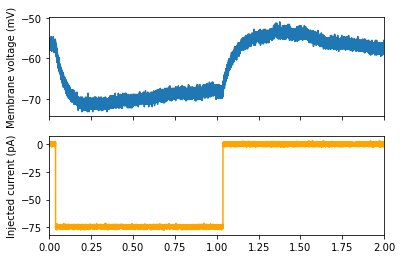

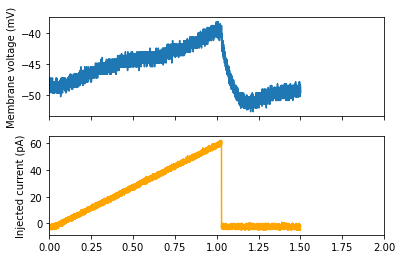

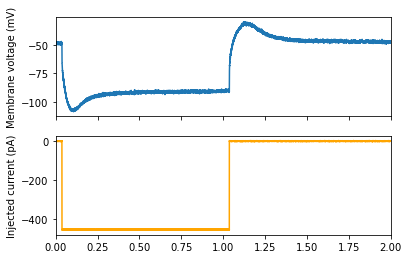

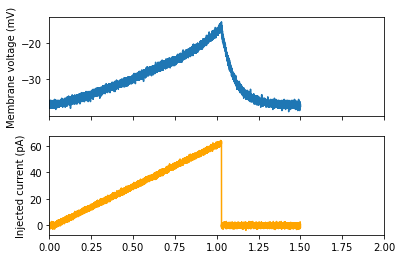

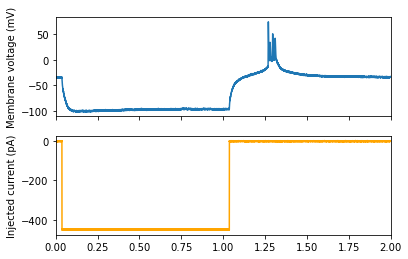

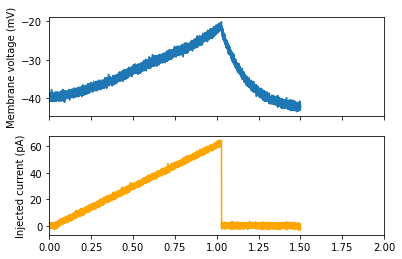

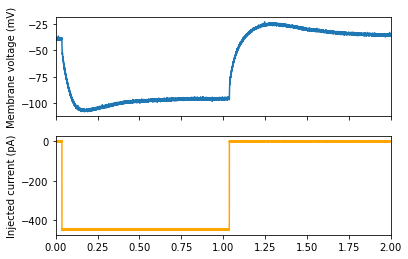

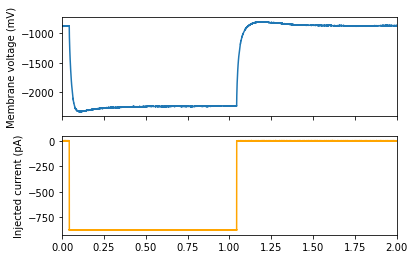

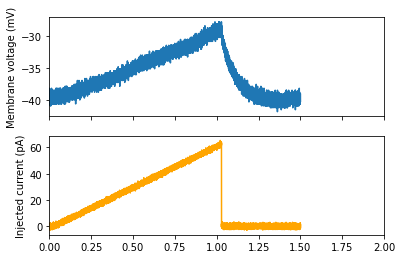

In [28]:
# plot all files with errors
for i, row in successes_df.iterrows():
    nwb_file = 'data/processed/recordings/mouse2018/' + row.file_id + ".nwb"
    plot_nwb_sweep(nwb_file, './data/stim_ontology_new_Homeira.json', 1, 0)
    
    
    
    